# Modelos de series temporales ARIMA(p,d,q)/SARIMA(p,d,q)(P,D,Q)

### Vamos a planter los siguientes modelos de ARIMA y SARIMA y en función de su valor del AIC eligiremos el mejor modelo.                                                               Haremos la descomposición de la serie temporal univariante, en este caso haremos la predicción a nivel nacional, no se tendrá en cuenta la provincia para realizar las predicciones.    Con la descomposición de la serien analizaremos sus componentes: Tendencia, Estacionariedad y sus Residuos. Con estos análisis obtendremos los parámetros de los modelos.

## 1. Análisis de la serie temporal ´modeloST_CTO_sin_outlier.csv´

In [1]:
# Importamos las librerías y cargamos el fichero de la serie temporal
import pandas as pd

path_file='C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/modeloST_CTO_sin_outlier.csv'

df_ST = pd.read_csv(path_file, sep=';')
print(f"Filas y columnas de la serie temporal: \n {df_ST.shape}\nCabecera del dataframe:\n {df_ST.head(5)}")
print(f"Los tipos de las variables:\n {df_ST.dtypes}")

Filas y columnas de la serie temporal: 
 (336, 5)
Cabecera del dataframe:
   Fecha de solicitud  Número de ampliaciones   Año  Semana Semana-Año
0         2019-01-20                     104  2019       3   2019-W03
1         2019-01-27                       3  2019       4   2019-W03
2         2019-02-03                      63  2019       5   2019-W03
3         2019-02-10                      23  2019       6   2019-W03
4         2019-02-24                      66  2019       8   2019-W03
Los tipos de las variables:
 Fecha de solicitud        object
Número de ampliaciones     int64
Año                        int64
Semana                     int64
Semana-Año                object
dtype: object


### Para la variable 'Fecha de solicitud' le cambiaremos el tipo a DataTime, y la varible de ´Número de ampliaciones' le cambiaremos el nombre a 'numero_ampliciones' para que no haya problema con la tilde y cambiremos el tipo a tipo float para tener más exactitud en la predicción, luego se redondeará.

In [2]:
df_ST['Fecha de solicitud']=pd.to_datetime(df_ST['Fecha de solicitud'], dayfirst=True, errors='coerce')
print(f"Cabecera de la var 'Fecha de solicitud'\n{df_ST['Fecha de solicitud'].head(5)}\nTipo de dato:\n{df_ST.dtypes}")

Cabecera de la var 'Fecha de solicitud'
0   2019-01-20
1   2019-01-27
2   2019-02-03
3   2019-02-10
4   2019-02-24
Name: Fecha de solicitud, dtype: datetime64[ns]
Tipo de dato:
Fecha de solicitud        datetime64[ns]
Número de ampliaciones             int64
Año                                int64
Semana                             int64
Semana-Año                        object
dtype: object


C:\Users\UX530\AppData\Local\Temp\ipykernel_7536\2020279917.py:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_ST['Fecha de solicitud']=pd.to_datetime(df_ST['Fecha de solicitud'], dayfirst=True, errors='coerce')


In [3]:
# Generamos la serie temporal incluyendo las variables de Fecha de solicitud y la variable target Número de Ampliaciones.
df_ST = df_ST.sort_values('Fecha de solicitud').reset_index(drop=True)
ts = df_ST.set_index('Fecha de solicitud')['Número de ampliaciones'].sort_index()
print("Rango:", ts.index.min(), ts.index.max(), "len:", len(ts))

Rango: 2019-01-20 00:00:00 2025-06-29 00:00:00 len: 336


In [4]:
# Comprobamos si tenemos nulos en nuestra serie.
if ts.isna().sum() > 0 and ts.isna().sum() <= 0.1*len(ts):
    print("Hay nulos, se interpola la serie")
    ts = ts.interpolate(method='time')
else:
    print("No hay nulos.")
    ts = ts.dropna()

No hay nulos.


In [5]:
# Vamos a detectar la frecuencia de la serie y forzamos a tenerla:
freq = pd.infer_freq(ts.index)
if freq is None:
    print("detectar delta mayoritario")
    deltas = ts.index.to_series().diff().dropna().value_counts()
    common = str(deltas.index[0])
    if '7 days' in common:
        print("Freq - 7")
        freq = 'W'
    elif '30 days' in common or '31 days' in common:
        print("Freq - 7")
        freq = 'M'
    else:
        freq = 'W'
    ts = ts.asfreq(freq).interpolate(method='time')

detectar delta mayoritario
Freq - 7


In [6]:
ts.head(5)

Fecha de solicitud
2019-01-20    104.0
2019-01-27      3.0
2019-02-03     63.0
2019-02-10     23.0
2019-02-17     44.5
Freq: W-SUN, Name: Número de ampliaciones, dtype: float64

### Con la serie temporal, procedemos a la descomposición:

Descomposición completada exitosamente.


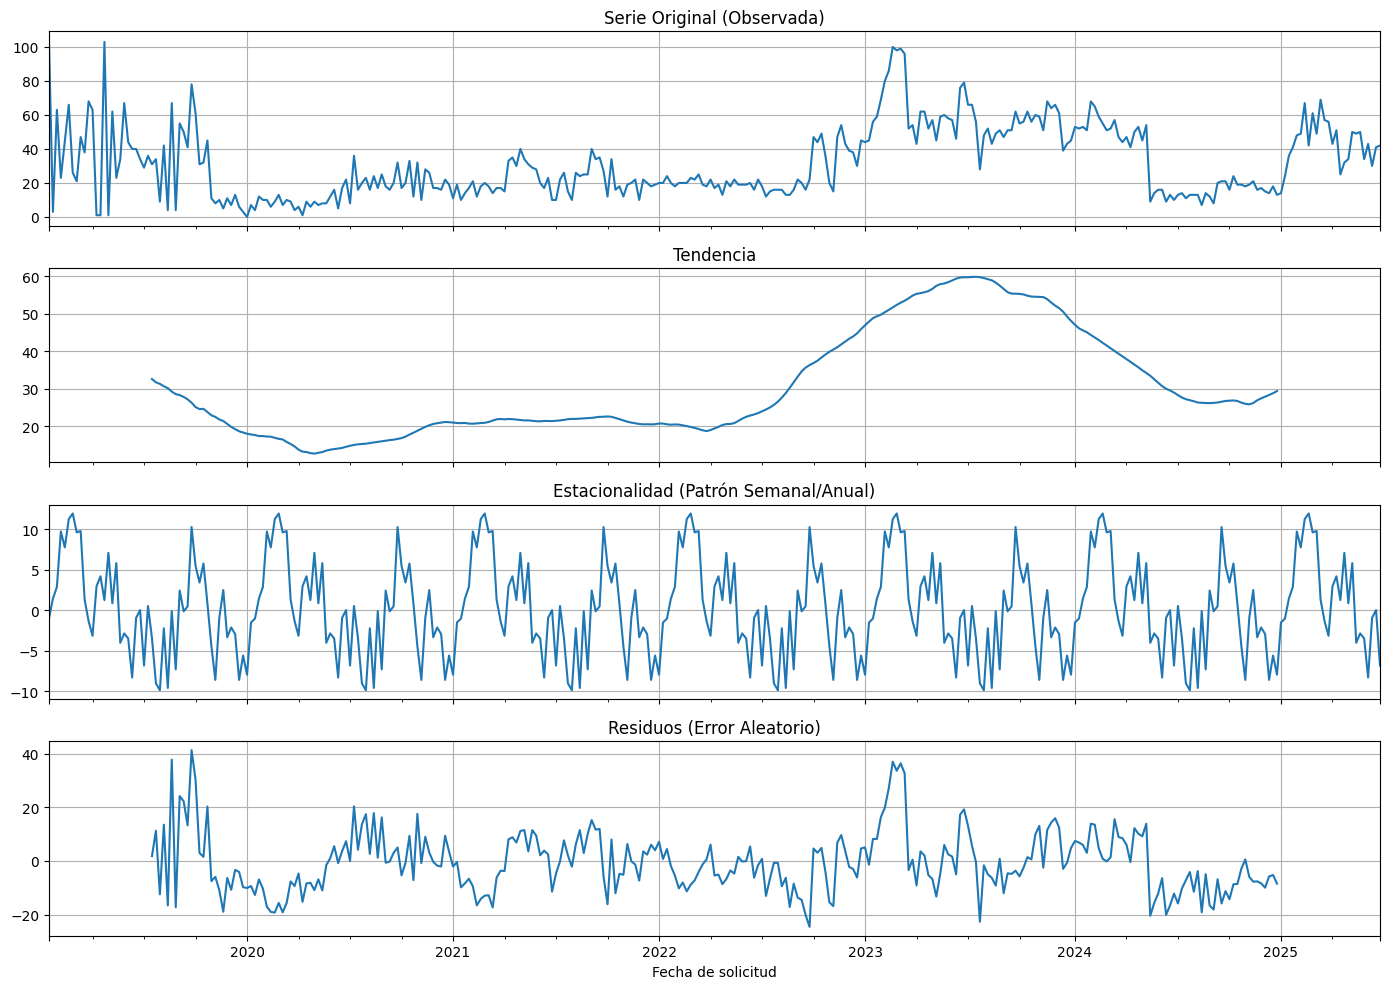

In [7]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

#ts_t = ts['Número de ampliaciones']
try:
    decomposition = seasonal_decompose(
        ts, 
        model='additive', 
        period=52 
    )
    print("Descomposición completada exitosamente.")
    
except ValueError as e:
    # Este error ocurre si la serie no tiene suficientes puntos (al menos dos ciclos completos)
    print(f"Error al aplicar period=52: {e}")
    print("Intentando con un período más corto (ej. period=4 para estacionalidad mensual aproximada).")
    decomposition = seasonal_decompose(
        ts, 
        model='additive',
        period=4
    )
    print("Descomposición completada con un período de 4.")



# Visualización de la descomposición de la serie temporal
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

decomposition.observed.plot(ax=axes[0], title='Serie Original (Observada)', grid=True)
decomposition.trend.plot(ax=axes[1], title='Tendencia', grid=True)
decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad (Patrón Semanal/Anual)', grid=True)
decomposition.resid.plot(ax=axes[3], title='Residuos (Error Aleatorio)', grid=True)
plt.tight_layout()
plt.show()

### Procedemos a separar los conjuntos de entrenamiento y test para realizar el análisis de estacionariedad.

In [8]:
# Separamos la serie en dos conjuntos de datos
split_date = pd.Timestamp("2024-06-30")
if ts.index.max() > split_date:
    train = ts[:split_date]
    test = ts[split_date + pd.Timedelta(days=1):]
else:
    split_idx = int(0.8*len(ts))
    train = ts.iloc[:split_idx]
    test = ts.iloc[split_idx:]


# Guardamos versiones limpias
ts.to_csv("C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/ts_clean.csv")
train.to_csv("C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/ts_train.csv")
test.to_csv("C:/Users/UX530/Desktop/TFM-GIT\Datasets_Files/ts_test.csv")

<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
C:\Users\UX530\AppData\Local\Temp\ipykernel_7536\1364037368.py:15: SyntaxWarning: invalid escape sequence '\D'
  test.to_csv("C:/Users/UX530/Desktop/TFM-GIT\Datasets_Files/ts_test.csv")


### Podemos observar que la serie tiene tendencia creciente, por eso realizaremos un estudio de estacionariedad ADF si el p-value es menor que 0.05 tendremos una serie estacionaria, en el caso que no lo sea, será necesario aplicar una diferenciación d=1.

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(train)

print('--- Prueba de Estacionariedad (ADF) ---')
print(f'Estadístico de prueba ADF: {resultado_adf[0]:.2f}')
print(f'Valor p (p-value): {resultado_adf[1]:.2f}')

# Interpretación: Si p-value > 0.05, la serie NO es estacionaria
if resultado_adf[1] > 0.05:
    print("CONCLUSIÓN: La serie NO es estacionaria. Se usará **ARIMA** (se requiere diferenciación).")
    d = 1 # Asumimos una diferenciación de orden 1
else:
    print("CONCLUSIÓN: La serie ES estacionaria. Se usará **ARMA**.")
    d = 0

--- Prueba de Estacionariedad (ADF) ---
Estadístico de prueba ADF: -2.45
Valor p (p-value): 0.13
CONCLUSIÓN: La serie NO es estacionaria. Se usará **ARIMA** (se requiere diferenciación).


In [10]:
# Guardamos la serie diferenciada y realizamos el estudio de la estacionariedad para ver si tenemos que aplicar d=2
ts_train_diff = train.diff().dropna()
resultado_adf = adfuller(ts_train_diff)

print('--- Prueba de Estacionariedad (ADF) ---')
print(f'Estadístico de prueba ADF: {resultado_adf[0]:.2f}')
print(f'Valor p (p-value): {resultado_adf[1]:.2f}')

# Interpretación: Si p-value > 0.05, la serie NO es estacionaria
if resultado_adf[1] > 0.05:
    print("CONCLUSIÓN: La serie NO es estacionaria. Se usará **ARIMA** (se requiere diferenciación).")
    d = 1 # Asumimos una diferenciación de orden 1
else:
    print("CONCLUSIÓN: La serie ES estacionaria. Se usará **ARMA**.")
    d = 0

--- Prueba de Estacionariedad (ADF) ---
Estadístico de prueba ADF: -4.83
Valor p (p-value): 0.00
CONCLUSIÓN: La serie ES estacionaria. Se usará **ARMA**.


Descomposición completada exitosamente.


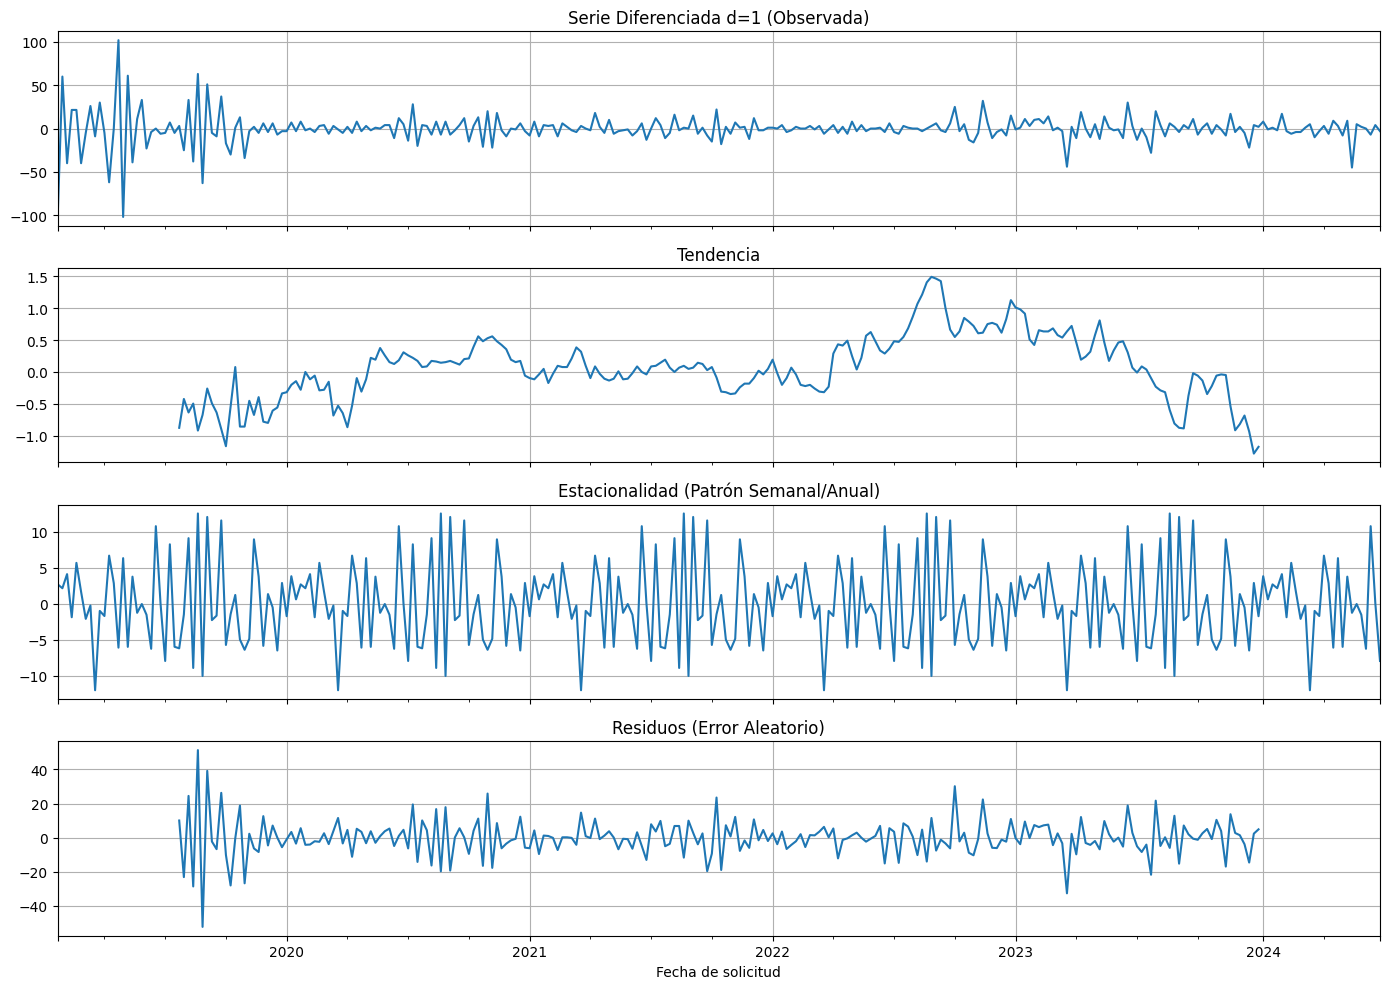

In [11]:
#Observamos la descomposición de la serie estacionaria
try:
    decomposition = seasonal_decompose(
        ts_train_diff, 
        model='additive', 
        period=52 
    )
    print("Descomposición completada exitosamente.")
    
except ValueError as e:
    # Este error ocurre si la serie no tiene suficientes puntos (al menos dos ciclos completos)
    print(f"Error al aplicar period=52: {e}")
    print("Intentando con un período más corto (ej. period=4 para estacionalidad mensual aproximada).")
    decomposition = seasonal_decompose(
        ts, 
        model='additive',
        period=4
    )
    print("Descomposición completada con un período de 4.")



# Visualización de la descomposición de la serie temporal
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

decomposition.observed.plot(ax=axes[0], title='Serie Diferenciada d=1 (Observada)', grid=True)
decomposition.trend.plot(ax=axes[1], title='Tendencia', grid=True)
decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad (Patrón Semanal/Anual)', grid=True)
decomposition.resid.plot(ax=axes[3], title='Residuos (Error Aleatorio)', grid=True)
plt.tight_layout()
plt.show()

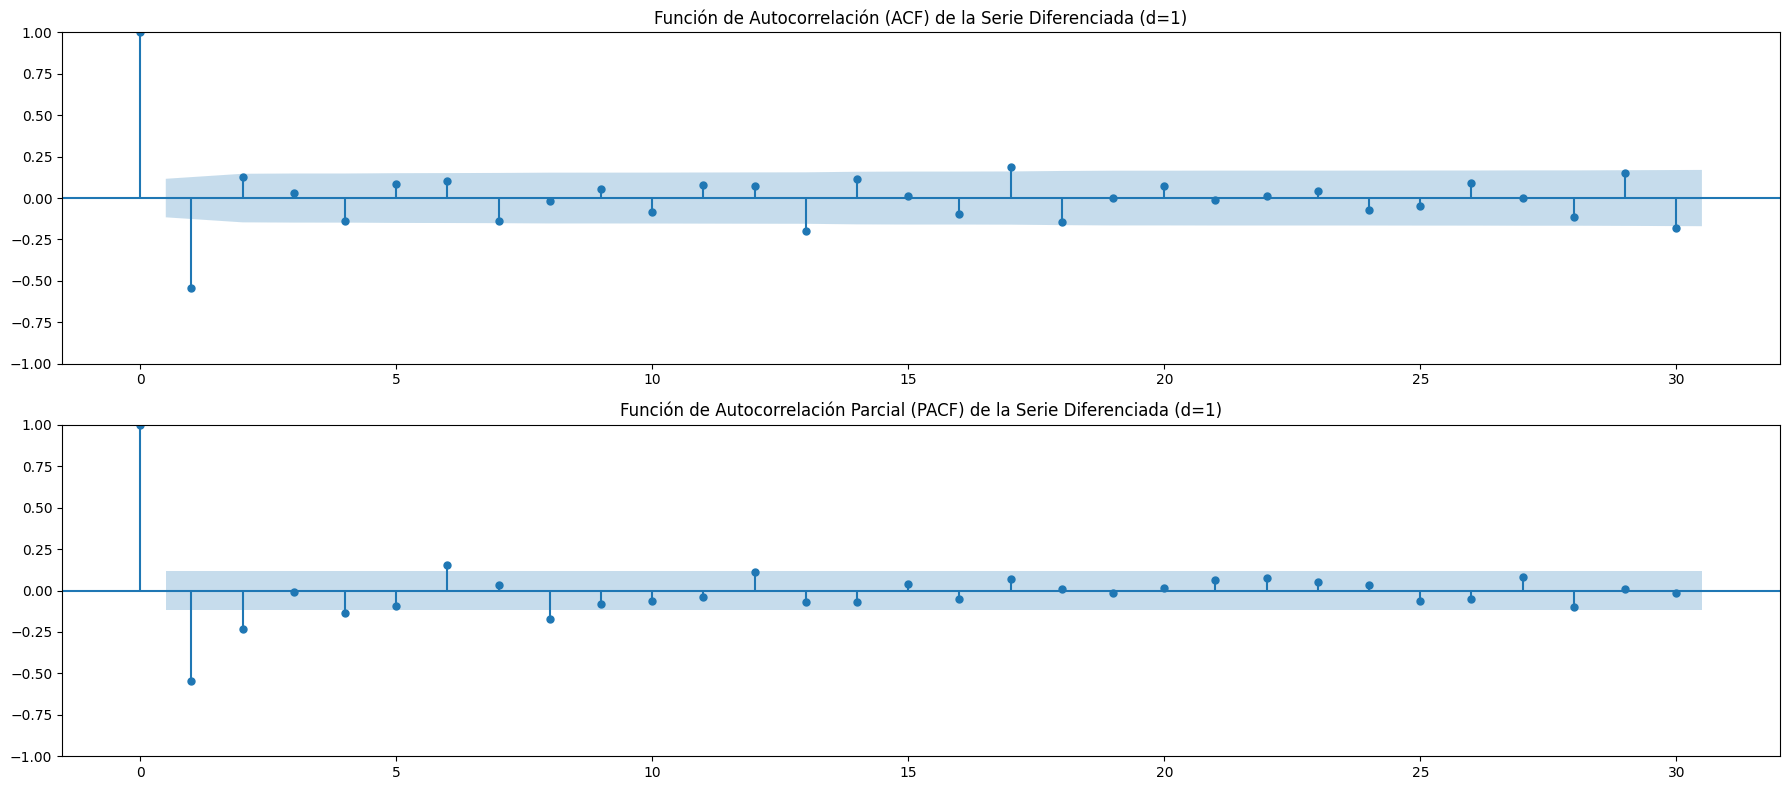

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotemoas las gráficas de autocorrelación (ACF) y autocorrelación parcial (PACF)
fig, ax = plt.subplots(2, 1, figsize=(18, 8))
# Gráfico de Autocorrelación (ACF)
plot_acf(ts_train_diff, lags=30, ax=ax[0])
ax[0].set_title('Función de Autocorrelación (ACF) de la Serie Diferenciada (d=1)')

# Gráfico de Autocorrelación Parcial (PACF)
plot_pacf(ts_train_diff, lags=30, ax=ax[1],
title='Función de Autocorrelación Parcial (PACF) de la Serie Diferenciada (d=1)')

plt.tight_layout()
plt.show()

### Observamos que tenemos que aplicar diferenciación de valor d=1 al obtener el valor de p-value < 0.05. Con la autocorrelación y la autocorrelación parcial tenemos valores significativos a partir del segundo lag, con lo que nos quedamos con p=2 y q=2. Aún con estos valores obtenidos v haremos la prueba del "best order" para obtener los parámetros que nos den el mejor AIC.

Mejor ARIMA ahora: (0, 0, 0) 2550.976794044482
Mejor ARIMA ahora: (0, 0, 1) 2449.1637686839613
Mejor ARIMA ahora: (0, 0, 2) 2375.0031351151574
Mejor ARIMA ahora: (0, 0, 3) 2326.5520749295156
Mejor ARIMA ahora: (0, 1, 1) 2266.3168091102784
Mejor ARIMA ahora: (0, 1, 2) 2255.150887151918
Mejor ARIMA ahora: (0, 1, 3) 2250.244333553172
Mejor ARIMA ahora: (0, 2, 3) 2245.25024784994
Mejor ARIMA ahora: (2, 1, 3) 2199.082631436666
Mejor ARIMA final: (2, 1, 3) 2199.082631436666
                                 SARIMAX Results                                  
Dep. Variable:     Número de ampliaciones   No. Observations:                  285
Model:                     ARIMA(2, 1, 3)   Log Likelihood               -1093.541
Date:                    Wed, 22 Oct 2025   AIC                           2199.083
Time:                            12:54:58   BIC                           2220.891
Sample:                        01-20-2019   HQIC                          2207.830
                             

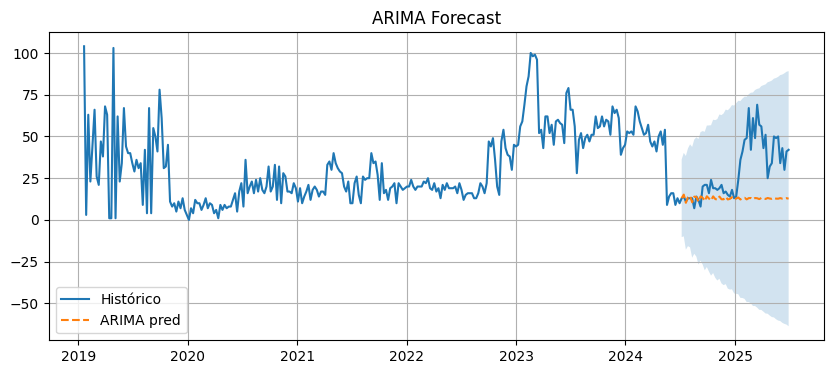

In [13]:
### Observamos que tenemos que aplicar diferenciación de valor 1, aún así haremos la prueba del best order para obtener los parámetros que nos den el mejor AIC.

from statsmodels.tsa.arima.model import ARIMA
import warnings, itertools
import numpy as np

p = range(0,4); d = range(0,3); q = range(0,4)
pdq = list(itertools.product(p,d,q))
best_aic = np.inf; best_order=None; best_res=None
for order in pdq:
    try:
        model = ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(method_kwargs={"warn_convergence": False})
        if np.isfinite(res.aic) and res.aic < best_aic:
            best_aic = res.aic; best_order = order; best_res = res
            print("Mejor ARIMA ahora:", best_order, best_aic)
    except Exception as e:
        continue

print("Mejor ARIMA final:", best_order, best_aic)

if best_res is not None:
    arima_res = best_res
    print(arima_res.summary())
    horizon_weeks = 52
    fc = arima_res.get_forecast(steps=horizon_weeks) #fc Forecast
    df_arima = pd.DataFrame({
        "fecha": pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=horizon_weeks, freq=pd.infer_freq(ts.index)),
        "pred": fc.predicted_mean.values, 
        "lower": fc.conf_int().iloc[:,0].values, 
        "upper": fc.conf_int().iloc[:,1].values
    }).set_index("fecha")
    df_arima.to_csv("C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/arima_forecast_2.csv")
    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(ts, label='Histórico')
    plt.plot(df_arima['pred'], linestyle='--', label='ARIMA pred')
    plt.fill_between(df_arima.index, df_arima['lower'], df_arima['upper'], alpha=0.2)
    plt.legend(); plt.title("ARIMA Forecast")
    plt.grid(True)
    plt.show()

### Hacemos el estudio de Estacionalidad para el modelo SARIMA

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
freq = pd.infer_freq(ts.index)
seasonal_period = 52 if freq and freq.upper().startswith('W') else 12

ps = range(0,3); ds = range(0,2); qs = range(0,3)
Ps = range(0,2); Ds = range(0,2); Qs = range(0,2)
best_aic = np.inf; best_sar=None; best_order=None; best_seasonal=None
for order in itertools.product(ps, ds, qs):
    for seasonal in itertools.product(Ps, Ds, Qs):
        try:
            model = SARIMAX(train, order=order, seasonal_order=(seasonal[0], seasonal[1], seasonal[2], seasonal_period),
                            enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False)
            if np.isfinite(res.aic) and res.aic < best_aic:
                best_aic = res.aic; best_sar = res; best_order=order; best_seasonal=seasonal
                print("Mejor SARIMAX:", best_order, best_seasonal, best_aic)
        except Exception:
            continue

print("Mejor SARIMAX final:", best_order, best_seasonal, best_aic)

if best_sar is not None:
    fc = best_sar.get_forecast(steps=52)
    pm = fc.predicted_mean; ci = fc.conf_int()
    df_sar = pd.DataFrame({
        "fecha": pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=52, freq=pd.infer_freq(ts.index)),
        "pred": pm.values, "lower": ci.iloc[:,0].values, "upper": ci.iloc[:,1].values
    }).set_index("fecha")
    df_sar.to_csv("C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/sarimax_forecast_2.csv")

Mejor SARIMAX: (0, 0, 0) (0, 0, 0) 2877.444536663225
Mejor SARIMAX: (0, 0, 0) (0, 0, 1) 2255.927301392763
Mejor SARIMAX: (0, 0, 0) (0, 1, 0) 2211.853091067583
Mejor SARIMAX: (0, 0, 0) (0, 1, 1) 1675.4930659931463
Mejor SARIMAX: (0, 0, 1) (0, 1, 1) 1551.9073869533695
Mejor SARIMAX: (0, 0, 1) (1, 1, 1) 1545.3510086479992
Mejor SARIMAX: (0, 0, 2) (0, 1, 1) 1494.4661934189241
Mejor SARIMAX: (0, 0, 2) (1, 1, 1) 1477.10748977955
Mejor SARIMAX: (0, 1, 0) (0, 1, 1) 1426.8598215881784
Mejor SARIMAX: (0, 1, 0) (1, 1, 1) 1388.8509649653747
Mejor SARIMAX: (0, 1, 1) (1, 1, 1) 1365.2187081358302
Mejor SARIMAX: (0, 1, 2) (1, 1, 1) 1359.4296205848334
Mejor SARIMAX final: (0, 1, 2) (1, 1, 1) 1359.4296205848334


                                      SARIMAX Results                                       
Dep. Variable:               Número de ampliaciones   No. Observations:                  285
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 52)   Log Likelihood                -674.715
Date:                              Tue, 21 Oct 2025   AIC                           1359.430
Time:                                      23:30:38   BIC                           1375.310
Sample:                                  01-20-2019   HQIC                          1365.870
                                       - 06-30-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3428      0.081     -4.236      0.000      -0.501      -0.184
ma.L2         -0.04

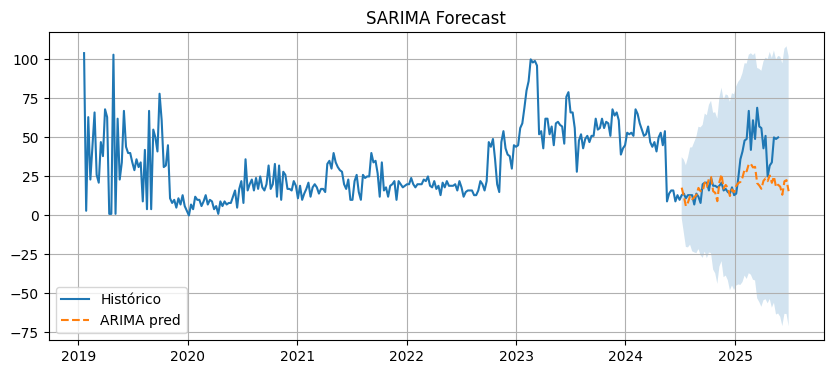

In [15]:

print(best_sar.summary())
# Plot
plt.figure(figsize=(10,4))
plt.plot(ts, label='Histórico')
plt.plot(df_sar['pred'], linestyle='--', label='ARIMA pred')
plt.fill_between(df_sar.index, df_sar['lower'], df_sar['upper'], alpha=0.2)
plt.legend(); plt.title("SARIMA Forecast")
plt.grid(True)
plt.show()